In [1]:
import numpy as np
import pandas as pd

import os
os.environ['NUMEXPR_MAX_THREADS'] = '12'

## Data preprocessing

In [2]:
alarm_path = "../datasets/with_topology/2/Alarm.csv"
topo_path = "../datasets/with_topology/2/Topology.npy"
dag_path = "../datasets/with_topology/2/DAG.npy"

In [3]:
# 历史告警
alarm_data = pd.read_csv(alarm_path, encoding ='utf')
# 拓扑图
topo_matrix = np.load(topo_path)
# 因果图
dag_matrix = np.load(dag_path)

In [4]:
# 可以添加 duration
# 告警序列非常多但是只有少数告警类型
display(alarm_data[:5])
display(set(alarm_data["alarm_id"]))

,alarm_id,device_id,start_timestamp,end_timestamp
0,11,0,14,28
1,14,2,22,24
2,11,3,59,198
3,12,22,61,79
4,0,34,69,77


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

In [5]:
topo_matrix.nonzero()

(array([ 0,  0,  1,  2,  3,  3,  3,  4,  4,  5,  5,  6,  7,  8,  8,  9,  9,
         9, 10, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 14, 14, 15, 16, 16,
        16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 19, 20, 21, 22, 23, 23,
        23, 24, 24, 25, 25, 26, 26, 27, 28, 29, 30, 30, 31, 31, 31, 32, 33,
        33, 34, 35, 35, 36, 36, 36, 37, 37, 38, 38, 38, 39, 40, 40, 41, 42,
        43, 44, 44, 45, 45, 45, 46, 47, 47]),
 array([ 9, 41, 11, 35, 17, 30, 34, 19, 31,  6, 47,  5, 38, 17, 43,  0, 17,
        28, 17,  1, 26, 33, 17, 42, 23, 24, 35, 44, 46, 16, 20, 16, 14, 15,
        36, 40,  3,  8,  9, 10, 12, 25, 33, 45, 37,  4, 14, 31, 30, 13, 25,
        36, 13, 27, 17, 23, 11, 32, 24,  9, 44,  3, 22,  4, 21, 45, 26, 11,
        17,  3,  2, 13, 16, 23, 38, 18, 45,  7, 36, 47, 40, 16, 39,  0, 12,
         8, 13, 29, 17, 31, 37, 13,  5, 38]))

In [6]:
dag_matrix.nonzero()

(array([ 3,  5,  6,  8,  8,  9, 10, 10, 10, 11, 11, 12, 12, 12, 12, 12, 13,
        13, 13, 14, 14, 14, 14, 14]),
 array([ 2,  4,  4,  2,  6,  6,  4,  5,  6,  0,  3,  4,  5,  8,  9, 10,  7,
         9, 10,  1,  2,  4,  7, 13]))

In [7]:
# baseline 方法测试
X = alarm_data.iloc[:,0:3]
X.columns=['event','node','timestamp']
X = X.reindex(columns=['event','timestamp','node'])
X

,event,timestamp,node
0,11,14,0
1,14,22,2
2,11,59,3
3,12,61,22
4,0,69,34
...,...,...,...
351457,4,605160,15
351458,4,605214,16
351459,4,605225,16
351460,4,605279,16


## Model

In [8]:
from castle.algorithms import TTPM
ttpm = TTPM(topo_matrix, max_iter=20, max_hop=2)

# 迭代时间非常长...
ttpm.learn(X)

est_causal_matrix = ttpm.causal_matrix.to_numpy()

np.save('../output/est_graphs/2.npy',est_causal_matrix)

2021-06-22 14:15:11,221 [iter 0]: likelihood_score = -2260785.050426164
2021-06-22 14:20:59,269 [iter 1]: likelihood_score = -2234057.2203537
2021-06-22 14:28:30,576 [iter 2]: likelihood_score = -2219038.9166551433
2021-06-22 14:36:24,568 [iter 3]: likelihood_score = -2204711.9161830354
2021-06-22 14:46:44,292 [iter 4]: likelihood_score = -2191974.4353783047
2021-06-22 14:57:58,643 [iter 5]: likelihood_score = -2180158.102233976
2021-06-22 15:09:55,894 [iter 6]: likelihood_score = -2171857.557321808
2021-06-22 15:22:31,399 [iter 7]: likelihood_score = -2165140.3092490425
2021-06-22 15:36:04,208 [iter 8]: likelihood_score = -2158995.81011989
2021-06-22 15:53:02,166 [iter 9]: likelihood_score = -2153076.5194911524
2021-06-22 16:08:37,100 [iter 10]: likelihood_score = -2147766.629503795
2021-06-22 16:23:14,201 [iter 11]: likelihood_score = -2142531.491291421
2021-06-22 16:39:09,485 [iter 12]: likelihood_score = -2137838.920710671
2021-06-22 16:54:02,696 [iter 13]: likelihood_score = -2133

## Evaluation

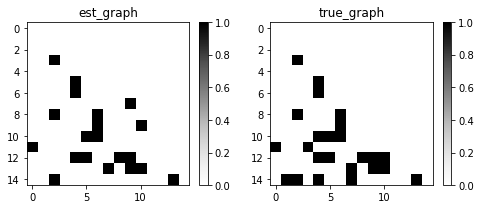

g-score: 0.6667


In [9]:
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
GraphDAG(est_causal_matrix, dag_matrix)
g_score = MetricsDAG(est_causal_matrix, dag_matrix).metrics['gscore']
print(f"g-score: {g_score}")
# iter 5: 0.2083
# iter 20: 0.6667

In [10]:
TP = []
FP = []
FN = []
for i in range(len(est_causal_matrix)):
    for j in range(len(est_causal_matrix)):
        if est_causal_matrix[i][j]==1 and dag_matrix[i][j]==1:
            TP.append((i, j))
        if est_causal_matrix[i][j]==1 and dag_matrix[i][j]==0:
            FP.append((i, j))
        if est_causal_matrix[i][j]==0 and dag_matrix[i][j]==1:
            FN.append((i, j))
display("TP {}".format(len(TP)))
display("FP {}".format(len(FP)))
display("FN {}".format(len(FN)))

'TP 18'

'FP 2'

'FN 6'

In [11]:
import networkx as nx
from pyvis.network import Network

est_net = Network("500px", "900px", notebook=True, directed=True, layout=False)

est_g = nx.from_numpy_matrix(est_causal_matrix)

est_net.from_nx(est_g)
est_net.show("../output/draw_graphs/est_graph.html")

In [12]:
true_net = Network("500px", "900px", notebook=True, directed= True, layout=False)

true_g = nx.from_numpy_matrix(dag_matrix)

true_net.from_nx(true_g)
true_net.show("../output/draw_graphs/true_graph.html")

In [13]:
topo_net = Network("500px", "900px", notebook=True, directed= True, layout=False)

topo_g = nx.from_numpy_matrix(topo_matrix)

topo_net.from_nx(topo_g)
topo_net.show("../output/draw_graphs/topo.html")